In [1]:
# inspired from: A deep understanding of deep learning


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T


import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


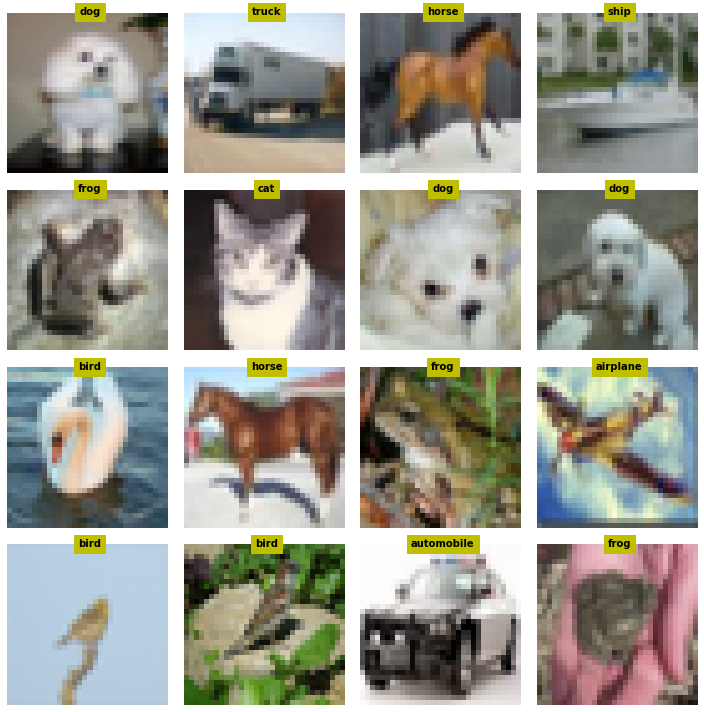

In [4]:
X,y = next(iter(train_loader))


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # need to transpose it back to 32x32x3
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  
  label = trainset.classes[y[i]]

  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')


plt.tight_layout()
plt.show()

In [5]:
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      self.print = printtoggle

      ### -------------- encoding layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (32+2*1-4)/2 + 1 = 16

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (16+2*1-4)/2 + 1 = 8

      # third convolution layer (latent code layer)
      self.latent  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (8+2*1-4)/2 + 1 = 4
      

      ### -------------- decoding layers -------------- ###
      
      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      # third convolution layer (output)
      self.output  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)




    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first encoder layer
      x = F.leaky_relu( self.encconv1(x) )
      if self.print: print(f'First encoder block: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu( self.encconv2(x) )
      if self.print: print(f'Second encoder block: {list(x.shape)}')

      # latent layer
      x = F.leaky_relu( self.latent(x) )
      if self.print: print(f'Third encoder block: {list(x.shape)}')




      # first decoder block
      x = F.leaky_relu( self.decconv1(x) )
      if self.print: print(f'First decoder block: {list(x.shape)}')

      # second decoder block
      x = F.leaky_relu( self.decconv2(x) )
      if self.print: print(f'Second decoder block: {list(x.shape)}')

      # third decoder block (output)
      x = F.leaky_relu( self.output(x) )
      if self.print: print(f'Decoder output: {list(x.shape)}')


      return x






  net = aenet(printtoggle)
  
  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)





  return net,lossfun,optimizer



In [6]:
aenet,lossfun,optimizer = makeTheAENet(True)

X,y = iter(train_loader).next()
yHat = aenet(X)

loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
 
Loss:
tensor(0.2480, grad_fn=<MseLossBackward0>)


In [7]:
def funtion2trainTheAEModel(net,lossfun,optimizer):

  numepochs = 20
  
  net.to(device)

  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  for epochi in range(numepochs):

    net.train()
    batchLoss = []

    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      yHat = net(X)
      loss = lossfun(yHat,X)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())


    
    trainLoss[epochi] = np.mean(batchLoss)



    #### test performance
    net.eval()
    batchLoss = []

    for X,y in test_loader:

      X = X.to(device)
      y = y.to(device)

      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)
      
      batchLoss.append(loss.item())


    testLoss[epochi] = np.mean(batchLoss)



  return trainLoss,testLoss,net
  

In [8]:
# ~5 minutes with 15 epochs on GPU

netAE,lossfun,optimizer = makeTheAENet()

trainLossAE,testLossAE,netAE = funtion2trainTheAEModel(netAE,lossfun,optimizer)

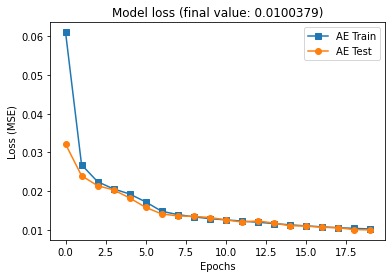

In [9]:
plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Model loss (final value: {testLossAE[-1]})')
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


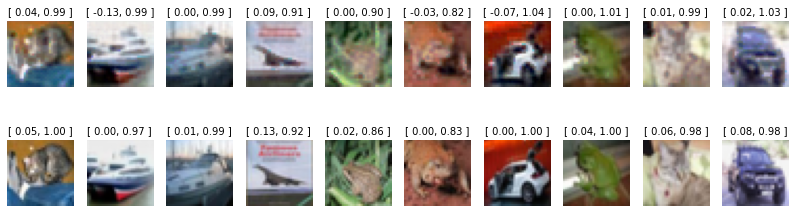

In [10]:
X,y = next(iter(test_loader))


netAE.cpu()
netAE.eval()

yHat = netAE(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')

  
plt.show()